# Predicting stock price moves with Logistic Regression

## Imports & Settings

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
from pathlib import Path
import sys, os
from time import time

import pandas as pd
import numpy as np

from scipy.stats import spearmanr

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import MultipleTimeSeriesCV

In [18]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [19]:
YEAR = 252

## Load Data

In [20]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))
data = data.drop([c for c in data.columns if 'year' in c or 'lag' in c], axis=1)

### Select Investment Universe

In [21]:
data = data[data.dollar_vol_rank<100]

### Create Model Data

In [22]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

In [23]:
y

target_1d  target_5d  target_10d  target_21d
ticker date                                                    
AAL    2013-07-25   0.013808   0.005775    0.000794   -0.007255
       2013-07-26   0.007334  -0.001787   -0.002597   -0.007757
       2013-07-29  -0.001560  -0.000625   -0.002153   -0.010307
       2013-07-30   0.007813  -0.002934   -0.015880   -0.010631
       2013-07-31   0.001550  -0.005011   -0.017793   -0.009130
...                      ...        ...         ...         ...
ZTS    2014-11-28  -0.012464  -0.004265   -0.007266   -0.001703
       2014-12-01   0.008339  -0.001220   -0.006092   -0.001459
       2014-12-02   0.003129  -0.004147   -0.009055   -0.001546
       2014-12-03  -0.019608  -0.009585   -0.008687   -0.001980
       2014-12-04  -0.000455  -0.005144   -0.001949   -0.001505

[109675 rows x 4 columns]

In [24]:
X

dollar_vol_1m        rsi   bb_high    bb_low       atr  \
ticker date                                                                 
AAL    2013-07-25  223614.661574  69.669475  0.011251  0.140777 -0.383445   
       2013-07-26  234821.351626  72.045207  0.007052  0.146370 -0.412740   
       2013-07-29  243001.954091  73.259776  0.008843  0.146963 -0.494894   
       2013-07-30  243122.621493  72.532538  0.018500  0.142355 -0.565684   
       2013-07-31  256336.659780  73.926238  0.016465  0.139949 -0.653399   
...                          ...        ...       ...       ...       ...   
ZTS    2014-11-28  294715.115434  71.884144  0.043559  0.157493  0.397024   
       2014-12-01  297525.671580  67.137279  0.051976  0.131103  0.403122   
       2014-12-02  298272.515355  68.612084  0.041573  0.120638  0.323857   
       2014-12-03  295315.035852  69.175766  0.038192  0.111125  0.236555   
       2014-12-04  286390.276661  61.677853  0.051743  0.080568  0.273293   

                       macd  return_1d  return_5d  return_10d  return_21d  \
ticker date                                                                 
AAL    2013-07-25  0.681257   0.017838   0.004413    0.008103    0.006426   
       2013-07-26  0.772848   0.013808   0.009262    0.008389    0.007936   
       2013-07-29  0.854980   0.007334   0.011627    0.007984    0.007873   
       2013-07-30  0.904814  -0.001560   0.012430    0.006755    0.007476   
       2013-07-31  0.954135   0.007813   0.009025    0.004774    0.006752   
...                     ...        ...        ...         ...         ...   
ZTS    2014-11-28  2.806829   0.005820   0.008117    0.003841    0.009878   
       2014-12-01  2.691178  -0.012464   0.002269    0.002815    0.008365   
       2014-12-02  2.615256   0.008339   0.000717    0.001147    0.009064   
       2014-12-03  2.540352   0.003129   0.004380    0.001551    0.008311   
       2014-12-04  2.329735  -0.019608  -0.003018    0.001374    0.005614   

                   ...  capital_goods  consumer_non-durables  \
ticker date        ...                                         
AAL    2013-07-25  ...          False                  False   
       2013-07-26  ...          False                  False   
       2013-07-29  ...          False                  False   
       2013-07-30  ...          False                  False   
       2013-07-31  ...          False                  False   
...                ...            ...                    ...   
ZTS    2014-11-28  ...          False                  False   
       2014-12-01  ...          False                  False   
       2014-12-02  ...          False                  False   
       2014-12-03  ...          False                  False   
       2014-12-04  ...          False                  False   

                   consumer_services  energy  finance  health_care  \
ticker date                                                          
AAL    2013-07-25              False   False    False        False   
       2013-07-26              False   False    False        False   
       2013-07-29              False   False    False        False   
       2013-07-30              False   False    False        False   
       2013-07-31              False   False    False        False   
...                              ...     ...      ...          ...   
ZTS    2014-11-28              False   False    False         True   
       2014-12-01              False   False    False         True   
       2014-12-02              False   False    False         True   
       2014-12-03              False   False    False         True   
       2014-12-04              False   False    False         True   

                   miscellaneous  public_utilities  technology  transportation  
ticker date                                                                     
AAL    2013-07-25          False             False       False            True  
       2013-07-26          F

## Logistic Regression

### Define cross-validation parameters

In [25]:
train_period_length = 63
test_period_length = 10
lookahead =1
n_splits = int(3 * YEAR/test_period_length)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [26]:
target = f'target_{lookahead}d'

We will continue with the price prediction example, but now we will binarize the outcome variable so that it takes on the value 1 whenever the 1-day return is positive and 0 otherwise:

The outcomes are slightly unbalanced, with more positive than negative moves:

In [27]:
y.loc[:, 'label'] = (y[target] > 0).astype(int)
y.label.value_counts()

label
1    56486
0    53189
Name: count, dtype: int64

In [28]:
Cs = np.logspace(-5, 5, 11)

In [29]:
cols = ['C', 'date', 'auc', 'ic', 'pval']

### Run cross-validation

In [30]:
%%time
log_coeffs, log_scores, log_predictions = {}, [], []
for C in Cs:
    print(C)
    model = LogisticRegression(C=C,
                               fit_intercept=True,
                               random_state=42,
                               n_jobs=-1)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    ics = aucs = 0
    start = time()
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train, = X.iloc[train_idx], y.label.iloc[train_idx]
        pipe.fit(X=X_train, y=y_train)
        X_test, y_test = X.iloc[test_idx], y.label.iloc[test_idx]
        actuals = y[target].iloc[test_idx]
        if len(y_test) < 10 or len(np.unique(y_test)) < 2:
            continue
        y_score = pipe.predict_proba(X_test)[:, 1]
       
        auc = roc_auc_score(y_score=y_score, y_true=y_test)
        actuals = y[target].iloc[test_idx]
        ic, pval = spearmanr(y_score, actuals)

        log_predictions.append(y_test.to_frame('labels').assign(
            predicted=y_score, C=C, actuals=actuals))
        date = y_test.index.get_level_values('date').min()
        log_scores.append([C, date, auc, ic * 100, pval])
        coeffs.append(pipe.named_steps['model'].coef_)
        ics += ic
        aucs += auc
        if i % 10 == 0:
            print(f'\t{time()-start:5.1f} | {i:03} | {ics/i:>7.2%} | {aucs/i:>7.2%}')

    log_coeffs[C] = np.mean(coeffs, axis=0).squeeze()

1e-05


	  6.7 | 010 |  -0.31% |  50.42%
	 11.8 | 020 |   1.89% |  51.83%
	 13.8 | 030 |   2.84% |  52.01%
	 16.0 | 040 |   3.29% |  51.98%
	 18.8 | 050 |   3.97% |  52.44%
	 20.0 | 060 |   3.96% |  52.27%
	 21.0 | 070 |   4.73% |  52.59%
0.0001
	  1.4 | 010 |  -0.06% |  50.62%
	  2.5 | 020 |   2.22% |  52.01%
	  3.6 | 030 |   3.20% |  52.26%
	  4.8 | 040 |   3.34% |  52.08%
	  6.1 | 050 |   4.02% |  52.52%
	  7.5 | 060 |   4.02% |  52.32%
	  8.9 | 070 |   4.82% |  52.67%
0.001
	  1.0 | 010 |   0.42% |  50.96%
	  2.2 | 020 |   2.53% |  52.14%
	  3.2 | 030 |   3.58% |  52.48%
	  4.4 | 040 |   3.17% |  52.07%
	  5.5 | 050 |   3.84% |  52.49%
	  6.8 | 060 |   4.03% |  52.33%
	  8.1 | 070 |   4.88% |  52.70%
0.01
	  1.4 | 010 |   0.69% |  51.14%
	  2.8 | 020 |   2.39% |  51.97%
	  4.2 | 030 |   3.64% |  52.41%
	  5.6 | 040 |   3.12% |  51.94%
	  7.0 | 050 |   3.91% |  52.45%
	  8.4 | 060 |   4.15% |  52.30%
	  9.6 | 070 |   4.90% |  52.64%
0.1
	  1.4 | 010 |   0.65% |  51.11%
	  2.7 | 020 |   2.15

### Evaluate Results

In [31]:
log_scores = pd.DataFrame(log_scores, columns=cols)
log_scores.to_hdf('data.h5', 'logistic/scores')

log_coeffs = pd.DataFrame(log_coeffs, index=X.columns).T
log_coeffs.to_hdf('data.h5', 'logistic/coeffs')

log_predictions = pd.concat(log_predictions)
log_predictions.to_hdf('data.h5', 'logistic/predictions')

In [32]:
log_scores = pd.read_hdf('data.h5', 'logistic/scores')

In [33]:
log_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   C       825 non-null    float64       
 1   date    825 non-null    datetime64[ns]
 2   auc     825 non-null    float64       
 3   ic      825 non-null    float64       
 4   pval    825 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 38.7 KB


In [34]:
log_scores.groupby('C').auc.describe()

,count,mean,std,min,25%,50%,75%,max
C,,,,,,,,
0.00001,75.0,0.524319,0.036129,0.432474,0.499748,0.519363,0.546010,0.625910
0.00010,75.0,0.525027,0.035672,0.442546,0.501468,0.520045,0.546001,0.635522
0.00100,75.0,0.525451,0.036366,0.438760,0.500371,0.520116,0.545270,0.641135
0.01000,75.0,0.525041,0.036924,0.435667,0.500665,0.522229,0.550606,0.641525
0.10000,75.0,0.523519,0.036514,0.427242,0.499618,0.522998,0.549215,0.622396
1.00000,75.0,0.523177,0.036477,0.425275,0.498439,0.521708,0.549034,0.616945
10.00000,75.0,0.523111,0.036482,0.424928,0.498357,0.521492,0.549019,0.616243
100.00000,75.0,0.523101,0.036484,0.424913,0.498355,0.521455,0.549040,0.616148
1000.00000,75.0,0.523100,0.036486,0.424894,0.498361,0.521451,0.549036,0.616153


### Plot Validation Scores

In [35]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)    
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

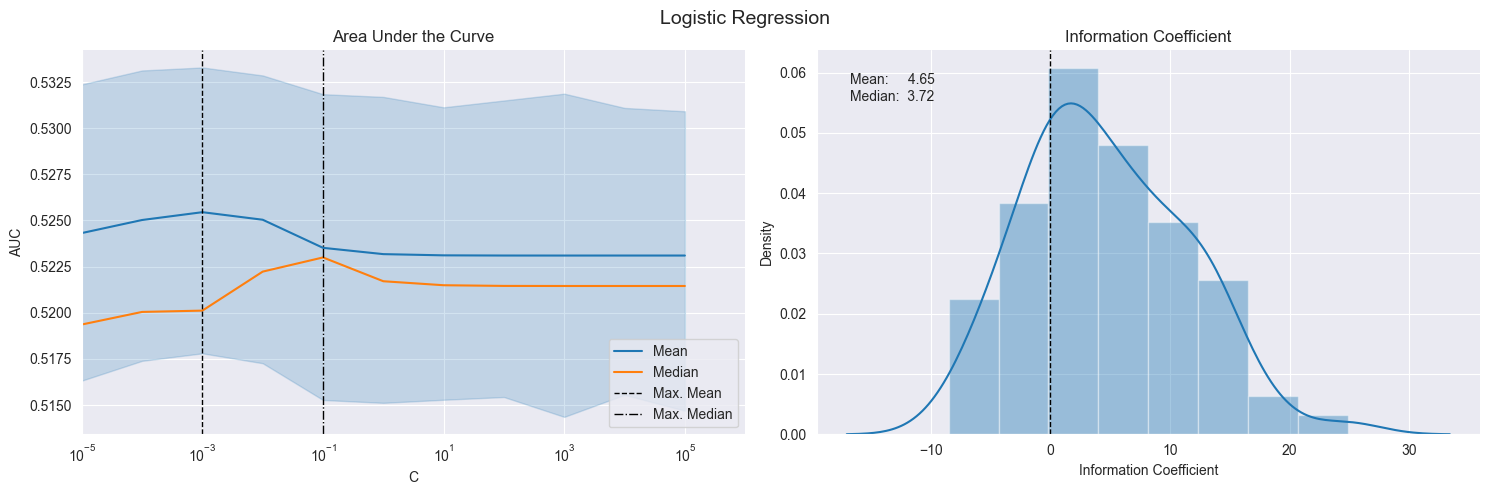

In [36]:
fig, axes= plt.subplots(ncols=2, figsize=(15, 5))

sns.lineplot(x='C', y='auc', data=log_scores, estimator=np.mean, label='Mean', ax=axes[0])
by_alpha = log_scores.groupby('C').auc.agg(['mean', 'median'])
best_auc = by_alpha['mean'].idxmax()
by_alpha['median'].plot(logx=True, ax=axes[0], label='Median', xlim=(10e-6, 10e5))
axes[0].axvline(best_auc, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(by_alpha['median'].idxmax(), ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_ylabel('AUC')
axes[0].set_xscale('log')
axes[0].set_title('Area Under the Curve')

plot_ic_distribution(log_scores[log_scores.C==best_auc], ax=axes[1])
axes[1].set_title('Information Coefficient')

fig.suptitle('Logistic Regression', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);